# Great Energy Predictor - Data Cleaning

<a id='content1'></a>
## Content

1. [Data Description](#description1)
2. [Imports](#imports1)
3. [Data Cleaning](#cleaning)
    - [Builing Cleaning](#cleaning_bldg)
    - [Weather Cleaning](#cleaning_wthr)
    - [Meter Cleaning](#cleaning_metr)
4. [Output](#output1)

<a id='description1'></a>
## 1. Data Description
[Back to top](#content1)

The data is a 2016 collection of energy meter readings (from over 1,000 buildings in 16 sites around the world) and weather measurements (from the nearest weather station for each site). It consists of 3 relational files of tabular data with the following features:
##### 1. train.csv - contains energy consumption measurements from 4 types of building meters in 2016
    - building_id - identifies the building
        - There are 1449 buildings in 16 sites around the world in this dataset
    - meter - meter type (not all buildings have all meter types)
        - 0 - electricity
        - 1 - chilldwater
        - 2 - steam
        - 3 - hotwater
    - timestamp - date and time of the meter reading
        - This dataset contains measurements over a span of an entire year
    - meter_reading - Energy consumption, in kilowatt-hour (kWh) or equivalent
        - The electric meter readings for site 0 are in kBTU
        - This is the target variable
##### 2. weather_train.csv - contains weather measurements in 2016 from the weather station that is closest to the site
    - site_id - identifies the site where the building is
    - timestamp - date and time of the weather measurements
    - air_temperature - air temperature, in degrees Celsius
    - cloud_coverage - portion of the sky covered by clouds, in oktas
    - dew_temperature - temperature at which dew forms, in degrees Celsius
    - precip_depth_1_hr - measure of rainfail in 1 hour, in millimeters (mm)
    - sea_level_pressure - atmospheric pressure at sea level, in millibar (mbar) or hectopascals (hPa)
    - wind_direction - compass direction of the wind (0 - 360)
    - wind_speed - wind speed, in meters per second (m/s)
##### 3. building_metadata.csv - contains details about the buildings in the dataset
    - site_id - identifies the site where the building is
    - building_id - identifies the building
    - primary_use - what the building is used for (based on EnergyStar's property types)
    - square_feet - gross floor area of the building, in square feet (ft^2)
    - year_built - year the building was opened
    - floor_count - number of floors the building has
    
This data was retrieved from a public Kaggle competition hosted by ASHRAE.
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction/data

<a id='imports1'></a>
## 2. Imports
[Back to top](#content1)

##### Import libraries

In [1]:
import gc
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns

# import ray.dataframe as pd
# from sklearn import impute

%matplotlib inline

In [2]:
plt = mpl.pyplot

# Default plot settings
sns.set(rc={'figure.figsize': (16, 6), 
            'font.size': 12})

# mpl.rcParams['figure.figsize'] = (16, 6)
# mpl.rcParams['font.size'] = 12

##### Import data

In [3]:
building = pd.read_csv('../data/raw/building_metadata.csv')
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [4]:
weather = pd.read_csv('../data/raw/weather_train.csv', parse_dates=['timestamp'])
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [5]:
meter = pd.read_csv('../data/raw/train.csv', parse_dates=['timestamp'])
meter.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


<a id='cleaning'></a>
## 3. Data Cleaning
To:
- [Building Cleaning](#cleaning_bldg)
- [Weather Cleaning](#cleaning_wthr)
- [Meter Cleaning](#cleaning_metr)
- [Top](#content1)

<a id='cleaning_bldg'></a>
### Building Cleaning
[Back to 3. Data Cleaning](#cleaning)

##### Inspect the data

In [6]:
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [7]:
building.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [8]:
# Check for duplicates
building.duplicated(subset=['building_id']).sum()

0

<a id='cleaning_ref1'></a>

There are no duplicate rows and most of the columns have a reasonable range of values and the correct data type. The 2 float columns (`year_built` and `floor_count`) make more sense as integer types but were cast as floating types due to the presence of missing values. These will be corrected after the missing values are filled. Another thing to note is that there are buildings that opened in 2016 and 2017, but this is dataset has measurements all throughout the 2016. Since this file only contains the metadata for the buildings, these buildings may not necessarily have measurements in the meter data so this discrepancy will be inspected more thoroughly when checking the meter data.

[Back to referencing cell](#cleaning_ref1_back)

As for the missing values here, it's possible that a missing `floor_count` value means 0 (the building only has a ground floor)

##### Locate the missing values by site

In [9]:
bldg_bysite = building.groupby('site_id').count()
bldg_bysite

,building_id,primary_use,square_feet,year_built,floor_count
site_id,,,,,
0,105,105,105,105,0
1,51,51,51,40,51
2,135,135,135,94,0
3,274,274,274,132,0
4,91,91,91,89,91
5,89,89,89,88,89
6,44,44,44,0,0
7,15,15,15,14,15
8,70,70,70,0,70


In [10]:
# Calculate missing year_built values
bldg_bysite['missing_year'] = bldg_bysite.building_id - bldg_bysite.year_built
bldg_bysite['pct_missing_year'] = bldg_bysite.missing_year * 100 // bldg_bysite.building_id

# Calculate missing floor_count values
bldg_bysite['missing_floor'] = bldg_bysite.building_id - bldg_bysite.floor_count
bldg_bysite['pct_missing_floor'] = bldg_bysite.missing_floor * 100 // bldg_bysite.building_id

# Refactor dataframe
missing_bysite = bldg_bysite[['building_id', 'year_built', 'floor_count', 'missing_year', 'missing_floor', 'pct_missing_year', 'pct_missing_floor']]
missing_bysite.columns = ['count_building', 'count_year', 'count_floor', 'missing_year', 'missing_floor', 'pct_missing_year', 'pct_missing_floor']
missing_bysite

,count_building,count_year,count_floor,missing_year,missing_floor,pct_missing_year,pct_missing_floor
site_id,,,,,,,
0,105,105,0,0,105,0,100
1,51,40,51,11,0,21,0
2,135,94,0,41,135,30,100
3,274,132,0,142,274,51,100
4,91,89,91,2,0,2,0
5,89,88,89,1,0,1,0
6,44,0,0,44,44,100,100
7,15,14,15,1,0,6,0
8,70,0,70,70,0,100,0


In [11]:
del bldg_bysite

More than half the sites are missing a `floor_count` value for all of their buildings. This means that the missing values could be due to an error in data collection, so it's not actually safe to assume that a missing `floor_count` value means 0. This combined with the fact that there are no recorded 0s probably means that a `floor_count` of 1 actually means a 1-story building.

There may be a correlation (possibly weak)* between the `floor_count` and `square_feet` of buildings. If there is a distinguishable pattern here, the missing `floor_count` values can be imputed based on how much `square_feet` the building has.

*Note: A building with 4 floors is expected to have a higher gross floor area than a building with 2 floors. It's a simple correlation, but this is not definite. If a building with 2 floors was built on a greater land area, it's possible that it could have a higher gross floor area than a building with 4 floors.

##### Inspect the correlation between `floor_count` and `square_feet`

In [12]:
building.corr()

,site_id,building_id,square_feet,year_built,floor_count
site_id,1.000000,0.977283,0.082136,-0.187021,-0.468542
building_id,0.977283,1.000000,0.074312,-0.230185,-0.482477
square_feet,0.082136,0.074312,1.000000,0.109063,0.530298
year_built,-0.187021,-0.230185,0.109063,1.000000,0.099393
floor_count,-0.468542,-0.482477,0.530298,0.099393,1.000000


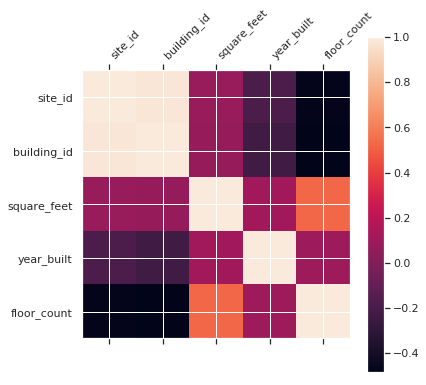

In [13]:
plt.matshow(building.corr())
plt.yticks(range(building.corr().shape[0]), building.corr().columns)
plt.xticks(range(building.corr().shape[0]), building.corr().columns, rotation=45, ha='left')
plt.colorbar()

Text(0.5, 0, 'Floor Count')

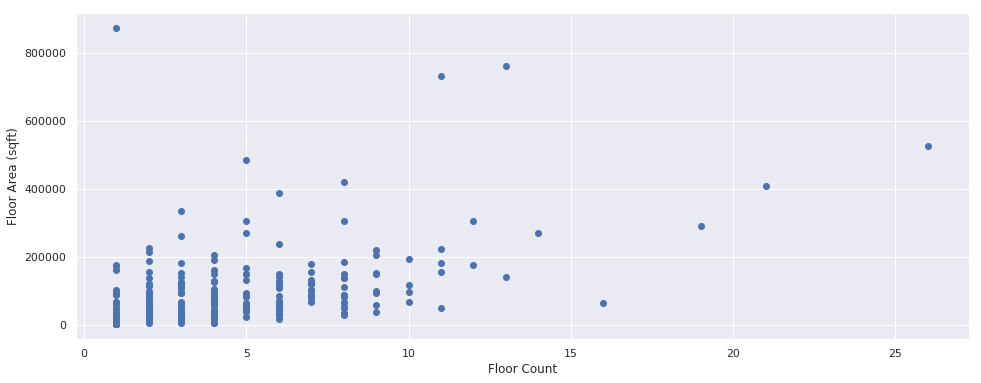

In [14]:
plt.scatter(building.floor_count, building.square_feet)
plt.ylabel('Floor Area (sqft)')
plt.xlabel('Floor Count')

In [15]:
# Count the number of buildings with each floor count
sqft_byfloorct = building.groupby('floor_count').count()[['square_feet']]
sqft_byfloorct.columns = ['count']

# Calculate the average, minimum and maximum square_feet by floor_count
sqft_byfloorct['avg_sqft'] = building.groupby('floor_count').mean().square_feet
sqft_byfloorct['min_sqft'] = building.groupby('floor_count').min().square_feet
sqft_byfloorct['max_sqft'] = building.groupby('floor_count').max().square_feet

sqft_byfloorct

,count,avg_sqft,min_sqft,max_sqft
floor_count,,,,
1.0,109,29046.357798,356,875000
2.0,67,47933.611940,4650,226042
3.0,33,78950.303030,4189,333681
4.0,37,61878.351351,4000,204998
5.0,25,105340.240000,21539,484376
6.0,25,93021.440000,16802,387500
7.0,14,111065.000000,66661,177281
8.0,19,112631.210526,27814,420885
9.0,8,126908.125000,36180,220703


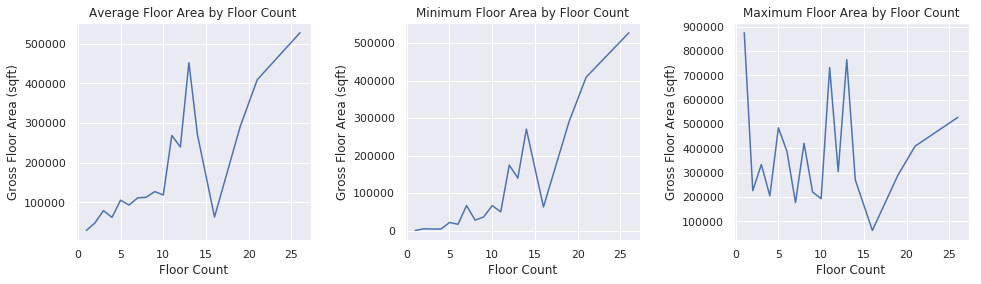

In [16]:
fig = plt.figure(figsize=(16, 4))

# Average square_feet
ax1 = fig.add_subplot(131)
ax1.plot(sqft_byfloorct.index.values, sqft_byfloorct.avg_sqft.values)
ax1.set_title('Average Floor Area by Floor Count')
ax1.set_ylabel('Gross Floor Area (sqft)')
ax1.set_xlabel('Floor Count')

# Minimum square_feet
ax2 = fig.add_subplot(132)
ax2.plot(sqft_byfloorct.index.values, sqft_byfloorct.min_sqft.values)
ax2.set_title('Minimum Floor Area by Floor Count')
ax2.set_ylabel('Gross Floor Area (sqft)')
ax2.set_xlabel('Floor Count')

# Maximum square_feet
ax3 = fig.add_subplot(133)
ax3.plot(sqft_byfloorct.index.values, sqft_byfloorct.max_sqft.values)
ax3.set_title('Maximum Floor Area by Floor Count')
ax3.set_ylabel('Gross Floor Area (sqft)')
ax3.set_xlabel('Floor Count')

plt.subplots_adjust(wspace=0.4)

There is a moderate positive correlation between `floor_count` and `square_feet`, as seen in the correlation matrix and 2 out of 3 line plots above. But with a Pearson coefficient of only 0.49, it wouldn't be a reliable base for imputing missing values. Not only this, but the range of `square_feet` values overlap with each other for different floor counts, which can make the decision of what values to impute very ambiguous. But the scatter plot above does show that there are quite a few outliers. Without these outliers the correlation would be much stronger.

##### Check the correlation again without the outliers

Text(0.5, 0, 'Floor Count')

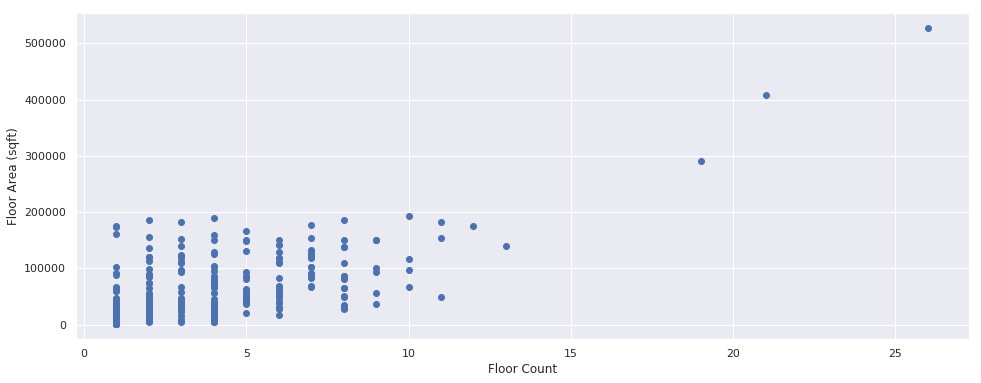

In [17]:
# Filter out outliers
outliers = building[(building.floor_count < 15) & (building.square_feet > 200000)].index
outliers_removed = building[building.floor_count != 16].drop(outliers)

# Replot the scatter plot
plt.scatter(outliers_removed.floor_count, outliers_removed.square_feet)
plt.ylabel('Floor Area (sqft)')
plt.xlabel('Floor Count')

In [18]:
outliers_removed.corr()

,site_id,building_id,square_feet,year_built,floor_count
site_id,1.000000,0.977776,0.093176,-0.188573,-0.487962
building_id,0.977776,1.000000,0.076589,-0.231990,-0.510981
square_feet,0.093176,0.076589,1.000000,0.127938,0.700279
year_built,-0.188573,-0.231990,0.127938,1.000000,0.069619
floor_count,-0.487962,-0.510981,0.700279,0.069619,1.000000


In [19]:
# Count the number of buildings with each floor count
sqft_byfloorct = outliers_removed.groupby('floor_count').count()[['square_feet']]
sqft_byfloorct.columns = ['count']

# Calculate the average, minimum and maximum square_feet by floor_count
sqft_byfloorct['avg_sqft'] = outliers_removed.groupby('floor_count').mean().square_feet
sqft_byfloorct['min_sqft'] = outliers_removed.groupby('floor_count').min().square_feet
sqft_byfloorct['max_sqft'] = outliers_removed.groupby('floor_count').max().square_feet

sqft_byfloorct

,count,avg_sqft,min_sqft,max_sqft
floor_count,,,,
1.0,108,21213.453704,356,175618
2.0,65,42642.276923,4650,186840
3.0,31,64857.677419,4189,182986
4.0,36,57902.805556,4000,189425
5.0,22,71498.000000,21539,166514
6.0,23,73911.782609,16802,150695
7.0,14,111065.000000,66661,177281
8.0,17,83167.058824,27814,185200
9.0,6,98084.666667,36180,150887


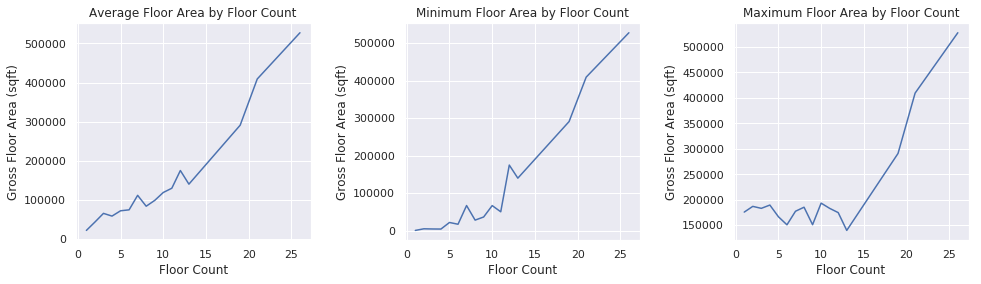

In [20]:
fig = plt.figure(figsize=(16, 4))

# Average square_feet
ax1 = fig.add_subplot(131)
ax1.plot(sqft_byfloorct.index.values, sqft_byfloorct.avg_sqft.values)
ax1.set_title('Average Floor Area by Floor Count')
ax1.set_ylabel('Gross Floor Area (sqft)')
ax1.set_xlabel('Floor Count')

# Minimum square_feet
ax2 = fig.add_subplot(132)
ax2.plot(sqft_byfloorct.index.values, sqft_byfloorct.min_sqft.values)
ax2.set_title('Minimum Floor Area by Floor Count')
ax2.set_ylabel('Gross Floor Area (sqft)')
ax2.set_xlabel('Floor Count')

# Maximum square_feet
ax3 = fig.add_subplot(133)
ax3.plot(sqft_byfloorct.index.values, sqft_byfloorct.max_sqft.values)
ax3.set_title('Maximum Floor Area by Floor Count')
ax3.set_ylabel('Gross Floor Area (sqft)')
ax3.set_xlabel('Floor Count')

plt.subplots_adjust(wspace=0.4)

In [21]:
del outliers, outliers_removed, sqft_byfloorct, fig, ax1, ax2, ax3

Removing the outliers resulted in a big improvement. The upward trend is much more apparent and the Pearson coefficient increased to 0.70. With this level of correlation, it would be an appropriate choice to fill the missing `floor_count` values based on the `square_feet` values.

Without the presence of outliers, the data forms a general linear trend so these missing values will be filled in a linear manner. Since the tallest recorded building in the dataset has 26 floors, these buildings will be divided into 26 bins based on their `square_feet` to impute the missing `floor_count` with.

##### Split the buildings with a missing `floor_count` into 26 bins based on their `square_feet` and use the bin number to fill the missing `floor_count`

In [22]:
# Extract buildings with missing floor_count
fc_missing = building[building.floor_count.isnull()]
fc_missing.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1094.000000,1094.000000,1094.000000,444.000000,0.0
mean,7.441499,744.232176,98509.699269,1972.673423,NaN
std,5.449910,457.974329,112558.032153,31.437338,NaN
min,0.000000,0.000000,283.000000,1900.000000,NaN
25%,3.000000,324.250000,26946.250000,1953.000000,NaN
50%,6.000000,777.500000,64006.500000,1975.000000,NaN
75%,13.000000,1174.750000,122474.500000,2002.000000,NaN
max,15.000000,1448.000000,861524.000000,2017.000000,NaN


In [23]:
# Create 26 bins for square_feet
fc_missing['bins'] = pd.cut(fc_missing.square_feet, bins=26, labels=range(1, 27), include_lowest=True).astype(int)
fc_missing.bins.value_counts()

/home/tri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1     323
2     242
3     172
4     111
5      57
6      48
7      32
8      26
9      22
12     15
11      9
10      8
13      7
15      4
17      4
14      3
18      3
25      2
21      2
26      2
16      1
23      1
Name: bins, dtype: int64

In [24]:
# Fill missing floor_count
building.loc[building.floor_count.isnull(), 'floor_count'] = fc_missing.bins
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    1449 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [25]:
del fc_missing

For the `year_built`, exactly half of the sites are missing this value for all of their buildings. As for the other half, only site 0 is not missing any values for `year_built`. 

##### Check the `year_built` value counts by site

In [26]:
yrbuilt_bysite = missing_bysite[missing_bysite.pct_missing_year != 100].drop(['count_floor', 'missing_floor', 'pct_missing_floor'], axis=1)
yrbuilt_bysite

,count_building,count_year,missing_year,pct_missing_year
site_id,,,,
0,105,105,0,0
1,51,40,11,21
2,135,94,41,30
3,274,132,142,51
4,91,89,2,2
5,89,88,1,1
7,15,14,1,6
15,124,113,11,8


/home/tri/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tri/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


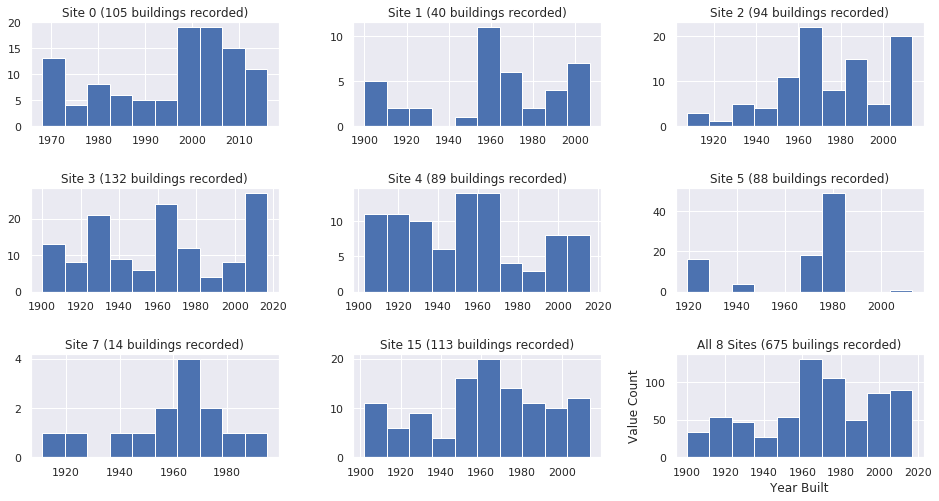

In [27]:
fig = plt.figure(figsize=(16, 8))

# Plot the year counts for each of the 8 sites that have year_built values
for i in range(yrbuilt_bysite.shape[0]):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.hist(building[building.site_id == yrbuilt_bysite.index.values[i]].year_built)
    ax.set_title('Site %d (%d buildings recorded)' % (yrbuilt_bysite.index[i], yrbuilt_bysite.iloc[i, 1]))
    
# Plot the year counts for all 8 sites combined
ax = fig.add_subplot(3, 3, 9)
ax.hist(building.year_built)
ax.set_title('All 8 Sites (%d builings recorded)' % yrbuilt_bysite.count_year.sum())
ax.set_ylabel('Value Count')
ax.set_xlabel('Year Built')

plt.subplots_adjust(wspace=0.3, hspace=0.6)

In [28]:
print('Mean:', int(building.year_built.mean()))
print('Median:', int(building.year_built.median()))
print('Mode:', int(building.year_built.mode()))

Mean: 1967
Median: 1970
Mode: 1976


All sites have a large portion of their buildings open some time between 1960 and 1980, except for site 0, which has a lot of newer buildings (that opened after the year 2000). Naturally, the mean, median, and mode all fall in this range as well. The median will be chosen for this feature on a site basis. Using each sites' median is more likely to be a closer approximation than using the total median for all sites. It may be okay for most sites, but most of site 0's buildings were built after the year 2000. For this case, it would make more sense to impute with a year after 2000. For this reason, the missing `year_built` values of these 7 sites will be filled with their respective medians. The motivation for this method is that buildings in the same site were possibly built around the same time.

##### Fill the missing `year_built` values with the corresponding site's median

In [29]:
building.year_built = building.groupby('site_id').year_built.transform(lambda y: y.fillna(y.median()))
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     884 non-null float64
floor_count    1449 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


As for the remaining 8 sites, a different method will have to be used. Since these sites are missing 100% of the `year_built` data, there is no median to compute. The `year_built` values for these sites will have to be based on another building feature.

##### Check the median by the building type

In [30]:
yb_byuse = building.groupby('primary_use').year_built.median()
yb_byuse

primary_use
Education                        1964.00
Entertainment/public assembly    1963.50
Food sales and service           1992.75
Healthcare                       1990.00
Lodging/residential              1968.00
Manufacturing/industrial         1969.00
Office                           1970.00
Other                            1972.00
Parking                          2002.00
Public services                  1961.50
Religious worship                1964.00
Retail                           1990.50
Services                             NaN
Technology/science               1942.00
Utility                          1981.75
Warehouse/storage                1975.00
Name: year_built, dtype: float64

(1920, 2020)

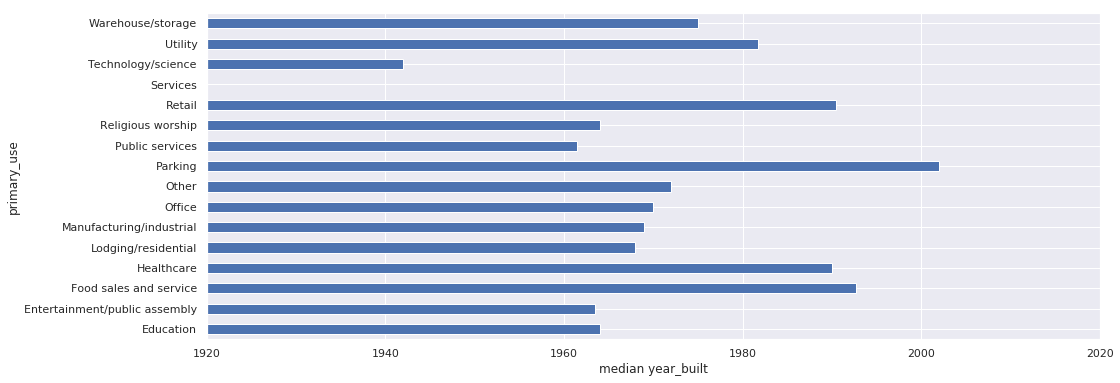

In [31]:
yb_byuse.plot(kind='barh')
plt.xlabel('median year_built')
plt.xlim(1920, 2020)

In [32]:
del missing_bysite, yrbuilt_bysite, yb_byuse, fig, ax, i

All building types except for services buildings were able to produce a median so these will be used to fill the remaining missing values. As for the services buildings, the first fill method will be used (by site). After imputing by `primary_use`, the remaining 8 sites will most likely be populated with some buildings, which allows for the median to be computed. These medians will then be used to fill the last of the missing values.

##### Fill the rest of the missing `year_built` values

In [33]:
# Impute using median year_built by primary_use
building.year_built = building.groupby('primary_use').year_built.transform(lambda y: y.fillna(y.median()))
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     1439 non-null float64
floor_count    1449 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [34]:
# Inpute using median year_built by site_id
building.year_built = building.groupby('site_id').year_built.transform(lambda y: y.fillna(y.median()))
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     1449 non-null float64
floor_count    1449 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


##### Cast `year_built` and `floor_count` as integer types

In [35]:
building.year_built = building.year_built.astype(int)
building.floor_count = building.floor_count.astype(int)

<a id='cleaning_wthr'></a>
### Weather Cleaning
[Back to 3. Data Cleaning](#cleaning)

##### Inspect the data

In [36]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


In [37]:
weather.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [38]:
# Check for duplicates
weather.duplicated(subset=['site_id', 'timestamp']).sum()

0

In [39]:
# 16 sites in the data, 366 days in 2016 (Feb 29), 24 hours in a day
print(f'There should be {16 * 366 * 24} timestamps')

There should be 140544 timestamps


Since measurements are recorded every hour, there should be a total of 140,544 records but there are actually only 139,773. This means that there are almost 1000 hours among these 16 sites that are missing every weather measurement.

##### Add in these missing timestamps and inspect the data again

In [40]:
# # Hourly date range for 2016
# timestamps = pd.date_range(start='1/1/2016 00:00:00', end='12/31/2016 23:00:00', freq='H')

# # List of dataframes of date ranges (one for each site)
# time_bysite = []
# for site in weather.site_id.unique():
#     df = pd.DataFrame(timestamps, columns=['timestamp'])
#     df['site_id'] = site
#     df = df[['site_id', 'timestamp']]
#     time_bysite.append(df)
    
# # Stack the dataframes
# idx = pd.concat(time_bysite)

# # Reindex weather dataframe
# weather = pd.merge(full_idx, weather, how='left', on=['site_id', 'timestamp'])

In [41]:
weather.set_index(['site_id', 'timestamp'], inplace=True)

weather = weather.reindex(
    pd.MultiIndex.from_product([
        building.site_id.unique(), 
        pd.date_range(start='1/1/2016 00:00:00', end='12/31/2016 23:00:00', freq='H')
    ])
)

weather.index.rename(['site_id', 'timestamp'], inplace=True)
weather.reset_index(inplace=True)

weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [42]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 9 columns):
site_id               140544 non-null int64
timestamp             140544 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.7 MB


In [43]:
# del idx, timestamps, time_bysite, df, site

There are no duplicates here and most of the columns have a reasonable range of values and the correct data type.

Discrepancies:
1. Data types: There are 3 columns that were recorded as integers but is currently cast as floating types due to the presence of missing values: `cloud_coverage`, `precip_depth_1_hr`, and `wind_direction`. These columns can be recast after the missing values have been filled. 
2. Values:
    - The `precip_depth_1_hr` column has a negative value: -1. According to the competition host*, the -1 represents trace precipitation. As these observations are recording an insignificantly small amount of rain, there isn't much weight to these values, but it may be better to encode them as a small positive value like 0.01 and keep the column as floating type.
    - The `wind_direction` column has both 0 and 360, which are the same in compass direction. Having the same value recorded as 2 different values on opposite ends on the range could be a major problem. They should be changed to all 0 or all 360.

*Source: https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113103#latest-664978

##### Replace all the -1 in the `precip_depth_1_hr` column with 0.01 and all the 0 in the `wind_direction` column with 360

In [44]:
# Replace -1 in precip_depth_1_hr column
weather.precip_depth_1_hr = weather.precip_depth_1_hr.apply(lambda m: 0.01 if m == -1 else m)

# Replace 0 in wind_direction column
weather.wind_direction = weather.wind_direction.apply(lambda m: 360 if m == 0 else m)

weather.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,140544.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.500000,14.418106,2.149306,7.350158,1.048286,1016.158038,215.996764,3.560527
std,4.609789,10.626595,2.599150,9.790235,8.452025,7.629684,105.555770,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,0.000000,968.200000,10.000000,0.000000
25%,3.750000,7.200000,0.000000,0.600000,0.000000,1011.800000,130.000000,2.100000
50%,7.500000,15.000000,2.000000,8.300000,0.000000,1016.400000,230.000000,3.100000
75%,11.250000,22.200000,4.000000,14.400000,0.000000,1020.800000,310.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


A simple approach to filling missing data in time series data is to forward fill, that is, to fill them with the value from the previous observation (if available). This is an viable option for this data because measurements are recorded every hour. If there were changes in weather, the assumption is that no drastic change would occur in 1 hour so the previous measurement would be relatively close to the actual measurement.

Of course, there are situations where this method becomes less reliable, like (1) if the previous observation belongs to a different site or (2) when there are many consecutive missing observations (which increases the duration that data is missing). To avoid the first problem, the fill could be done by site, but this doesn't do anything for the second problem and doesn't work if all values in a site are missing. Forward fill also doesn't work for columns where there are no valid previous values, like if the 1st row is missing. These values can be filled using backward fill (same concept in reverse direction). There are two columns missing nearly half of the observations, which means they will likely run into this problem quite often: `cloud_coverage` and `precip_depth_1_hr`. To also mitigate the effects of the second problem, interpolation can be used with forward fill for better approximations. 

##### Locate the missing data

In [45]:
# Count values by site
missing_bysite = weather.groupby('site_id').count()

# Change value counts to missing counts
for col in weather.columns[2:]:
    missing_bysite[col] = missing_bysite.timestamp - missing_bysite[col]

# Change column names
missing_bysite.columns = [col if col == 'timestamp' else 'missing_' + col for col in missing_bysite.columns]
    
missing_bysite

,timestamp,missing_air_temperature,missing_cloud_coverage,missing_dew_temperature,missing_precip_depth_1_hr,missing_sea_level_pressure,missing_wind_direction,missing_wind_speed
site_id,,,,,,,,
0,8784,3,3830,3,1,85,250,0
1,8784,22,7083,22,8784,73,24,21
2,8784,2,2355,2,67,45,592,6
3,8784,8,3646,10,41,162,157,8
4,8784,1,4231,3,1318,74,106,1
5,8784,31,6059,31,8784,8784,324,32
6,8784,12,2994,12,2,177,781,41
7,8784,170,8784,193,8053,178,170,170
8,8784,3,3830,3,1,85,250,0


In [46]:
pctmissing_bysite = missing_bysite.copy()

# Change missing counts to missing percentage
for col in missing_bysite.columns[1:]:
    pctmissing_bysite[col] = round(missing_bysite[col] * 100 / missing_bysite.timestamp, 2)
    
# Change column names
pctmissing_bysite.columns = [col if col == 'timestamp' else 'pct_' + col for col in pctmissing_bysite.columns]

pctmissing_bysite

,timestamp,pct_missing_air_temperature,pct_missing_cloud_coverage,pct_missing_dew_temperature,pct_missing_precip_depth_1_hr,pct_missing_sea_level_pressure,pct_missing_wind_direction,pct_missing_wind_speed
site_id,,,,,,,,
0,8784,0.03,43.60,0.03,0.01,0.97,2.85,0.00
1,8784,0.25,80.64,0.25,100.00,0.83,0.27,0.24
2,8784,0.02,26.81,0.02,0.76,0.51,6.74,0.07
3,8784,0.09,41.51,0.11,0.47,1.84,1.79,0.09
4,8784,0.01,48.17,0.03,15.00,0.84,1.21,0.01
5,8784,0.35,68.98,0.35,100.00,100.00,3.69,0.36
6,8784,0.14,34.08,0.14,0.02,2.02,8.89,0.47
7,8784,1.94,100.00,2.20,91.68,2.03,1.94,1.94
8,8784,0.03,43.60,0.03,0.01,0.97,2.85,0.00


In [47]:
del missing_bysite, col

There's a lot of missing data in several columns so forward-filling may give less accurate approximations for these columns, even with interpolation. Some columns are even missing 100% of the data for certain sites so it would be impossible to fill in either direction. For these cases, other values in the site can be compared to corresponding values in other sites to see which ones have similar measurements. The logic is that if certain measurements are similar in 2 different sites, the 2 sites may be close to each other (or close enough to have similar weather) so the other site's values can also be used to fill the site with 100% missing data as an approximation for the missing data.

##### Plot the first month of a site missing little data and a site missing a lot of data to see what the missing data looks like

In [48]:
# Time interval to plot
start, end = datetime.date(2016, 1, 1), datetime.date(2016, 1, 31)

# Sites 7 and 15
weather07 = weather[weather.site_id == 7].drop('site_id', axis=1).set_index('timestamp')
weather15 = weather[weather.site_id == 15].drop('site_id', axis=1).set_index('timestamp')

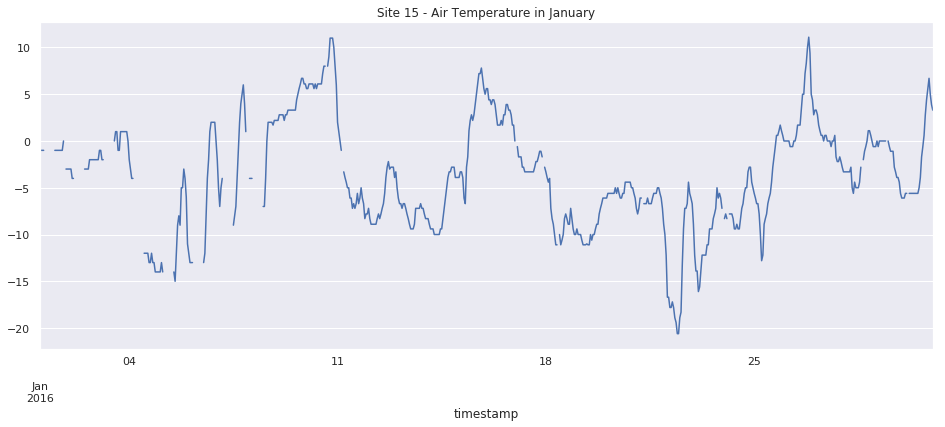

In [49]:
# Plot the air_temperature of site 15 in January
plt.title('Site 15 - Air Temperature in January')
weather15.loc[start:end, 'air_temperature'].plot()

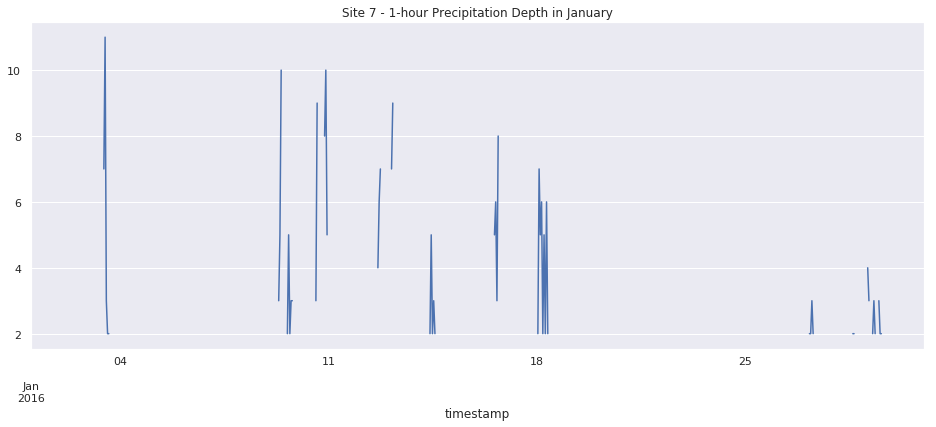

In [50]:
# Plot the precip_depth_1_hr of site 7 in January
plt.title('Site 7 - 1-hour Precipitation Depth in January')
weather07.loc[start:end, 'precip_depth_1_hr'].plot()

In [51]:
del start, end, weather07, weather15

The columns `cloud_coverage`, `wind_direction`, and `wind_speed` have constraints on their values so linear interpolation will be used with these in order to avoid negative values. The remaining 3 columns (`air_temperature`, `dew_temperature`, and `sea_level_pressure`) will use cubic interpolation for a smoother approximation. Precipitation behavior is erratic so there really isn't a pattern that can be approximated with interpolation. A simple forward and backward fill is a more suitable method for `precip_depth_1_hr`. Forward and backward fills will be used to fill the first and last null values.

##### Interpolate the weather data by site and inspect the data

In [52]:
for col in weather.columns[2:]:
    # Forward / backward fill
    if col == 'precip_depth_1_hr':
        weather[col] = weather.groupby('site_id')[col].transform(lambda s: s.fillna(method='ffill').fillna(method='bfill'))
    # Cubic interpolation
    if col in ['air_temperature', 'dew_temperature', 'sea_level_pressure']:
        weather[col] = weather.groupby('site_id')[col].transform(lambda s: s.interpolate('cubic', limit_direction='both').fillna(method='ffill').fillna(method='bfill'))
    # Linear interpolation
    else:
        weather[col] = weather.groupby('site_id')[col].transform(lambda s: s.interpolate('linear', limit_direction='both').fillna(method='ffill').fillna(method='bfill'))
        
# Check the missing matrix again
pctmissing_bysite = weather.groupby('site_id').count()
for col in weather.columns[2:]:
    pctmissing_bysite[col] = (pctmissing_bysite.timestamp - pctmissing_bysite[col]) * 100 / pctmissing_bysite.timestamp
pctmissing_bysite.columns = [col if col == 'timestamp' else '%m_' + col for col in pctmissing_bysite.columns]
pctmissing_bysite

,timestamp,%m_air_temperature,%m_cloud_coverage,%m_dew_temperature,%m_precip_depth_1_hr,%m_sea_level_pressure,%m_wind_direction,%m_wind_speed
site_id,,,,,,,,
0,8784,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8784,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2,8784,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8784,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8784,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,8784,0.0,0.0,0.0,100.0,100.0,0.0,0.0
6,8784,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8784,0.0,100.0,0.0,0.0,0.0,0.0,0.0
8,8784,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
weather.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,140544.000000,140544.000000,122976.000000,140544.000000,114192.000000,131760.000000,140544.000000,140544.000000
mean,7.500000,14.355589,2.633782,7.297783,2.780797,1016.147423,216.410348,3.561964
std,4.609789,10.669520,2.755691,9.826325,14.553411,7.653326,104.689136,2.333866
min,0.000000,-28.900000,0.000000,-35.000000,0.000000,968.200000,10.000000,0.000000
25%,3.750000,7.200000,0.000000,0.600000,0.000000,1011.700000,130.000000,2.100000
50%,7.500000,15.000000,2.000000,8.200000,0.000000,1016.400000,230.000000,3.100000
75%,11.250000,22.200000,4.000000,14.400000,0.010000,1020.800000,310.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


The minimum and maximum values haven't changed for any columns, so the range still looks good. All the missing data has been filled except for those with 100% missing values.

##### Replot the above 2 plots (site 15 air temperature and site 7 1-hour precipitation depth in January) to see how they were interpolated

In [54]:
# Time interval to plot
start, end = datetime.date(2016, 1, 1), datetime.date(2016, 1, 31)

# Sites 7 and 15
weather07 = weather[weather.site_id == 7].drop('site_id', axis=1).set_index('timestamp')
weather15 = weather[weather.site_id == 15].drop('site_id', axis=1).set_index('timestamp')

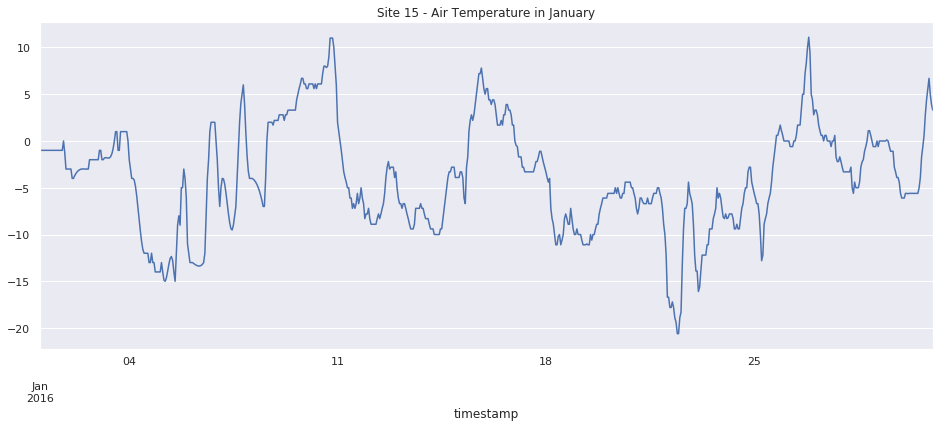

In [55]:
# Plot the air_temperature of site 15 in January
plt.title('Site 15 - Air Temperature in January')
weather15.loc[start:end, 'air_temperature'].plot()

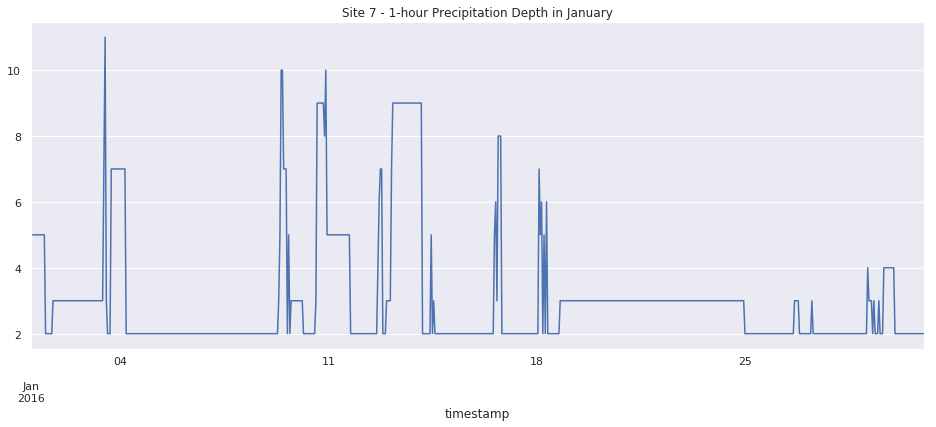

In [56]:
# Plot the precip_depth_1_hr of site 7 in January
plt.title('Site 7 - 1-hour Precipitation Depth in January')
weather07.loc[start:end, 'precip_depth_1_hr'].plot()

In [57]:
del start, end, weather07, weather15, col

The cubic interpolation on `air_temperature` looks seamless but the forward fill on `precip_depth_1_hr` is a little problematic. The problem with `precip_depth_1_hr` is that rainy timestamps are being propagated onto the timestamps that follow. It's possible that a constant rate of rain were recorded through the span of these missing values. But judging by the rest of the data, that's most likely not the case because they seem to be appearing in peaks rather than plateaus. Still though, cubic interpolation would introduce negative values and linear interpolation would result in the opposite problem as a simple forward fill. In other words, if values were missing after a non-rainy timestamp and the next available value is a rainy timestamp, linear interpolation would turn all timestamps in between into a positive precipitation depth, which is most likely not the case as they appear in peaks. It sounds like a similar problem to the forward fill but it also has a linear element to it that is less likely to be seen in the rest of the data, so the forward fill will continue to be used here.

Sites 1, 5, 7, 11, and 12 are still missing data in 1 or 2 of 3 columns: `cloud_coverage`, `precip_depth_1_hr`, and `sea_level_pressure`. These 5 sites will be compared with other sites using available data to see if there are any similar sites. If these sites have similar measurements in a correlated feature as another 1 of the 16 sites, then the similar sites' values for the missing feature can be used as a proxy for these sites' missing values.

##### Check the correlation between features

In [58]:
weather.corr()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,1.000000,-0.263368,0.025909,-0.204919,0.056260,-0.008857,0.047172,0.027808
air_temperature,-0.263368,1.000000,0.050606,0.792623,0.039634,-0.210008,-0.053116,-0.058498
cloud_coverage,0.025909,0.050606,1.000000,0.154841,0.079450,-0.092046,-0.083872,0.155142
dew_temperature,-0.204919,0.792623,0.154841,1.000000,0.086590,-0.172062,-0.087407,-0.098170
precip_depth_1_hr,0.056260,0.039634,0.079450,0.086590,1.000000,-0.063883,-0.027082,0.001687
sea_level_pressure,-0.008857,-0.210008,-0.092046,-0.172062,-0.063883,1.000000,-0.014861,-0.252133
wind_direction,0.047172,-0.053116,-0.083872,-0.087407,-0.027082,-0.014861,1.000000,-0.139952
wind_speed,0.027808,-0.058498,0.155142,-0.098170,0.001687,-0.252133,-0.139952,1.000000


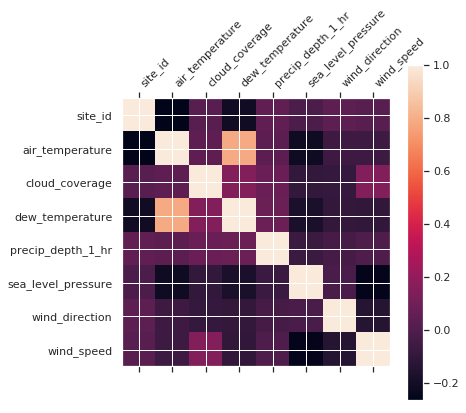

In [59]:
plt.matshow(weather.corr())
plt.yticks(range(weather.corr().shape[0]), weather.corr().columns)
plt.xticks(range(weather.corr().shape[0]), weather.corr().columns, rotation=45, ha='left')
plt.colorbar()

Unfortunately, the only strong correlation in the weather data exists between 2 features that are not missing any data. That will make this method less reliable, but for now, the most correlated feature will be used to determine similarity. The most correlated features for the columns with missing data are as follows:
- `cloud_coverage` - `wind_speed` (0.1551) and `dew_temperature` (0.1548)
- `precip_depth_1_hr` - `dew_temperature` (0.0866) and `cloud_coverage` (0.0795)
- `sea_level_pressure` - `wind_speed` (-0.2503) and `air_temperature` (-0.1926)

And the remaining missing data are as follows:
- Site 1: `precip_depth_1_hr`
- Site 5: `precip_depth_1_hr` and `sea_level_pressure`
- Site 7: `cloud_coverage`
- Site 11: `cloud_coverage`
- Site 12: `precip_depth_1_hr`

##### Find the most similar site for sites 1, 5, 7, 11, and 12 to fill their missing data based on the most correlated features

##### Cloud coverage

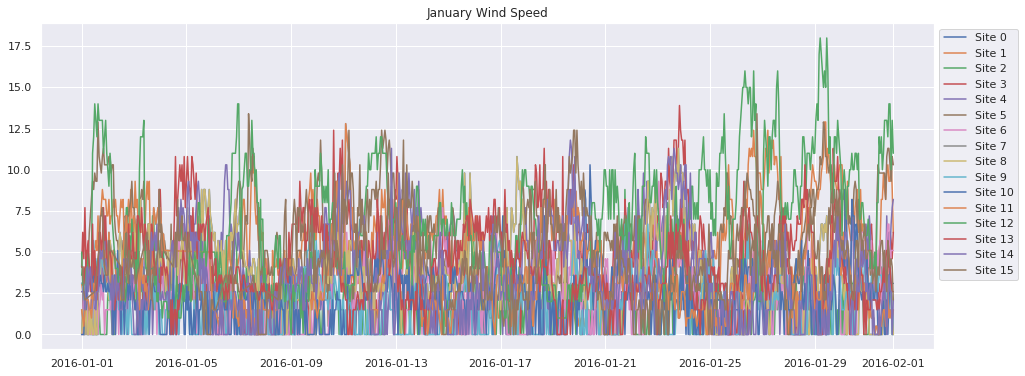

In [60]:
# Time interval to plot
start, end = datetime.date(2016, 1, 1), datetime.date(2016, 2, 1)

# Sites to plot
sites = weather.site_id.unique()

# Plot wind_speed
for site in sites:
    df = weather[weather.site_id == site].drop('site_id', axis=1).set_index('timestamp')
    plt.plot(df.loc[start:end, 'wind_speed'], label=f'Site {site}')
plt.title('January Wind Speed')
plt.legend(bbox_to_anchor=(1, 1))

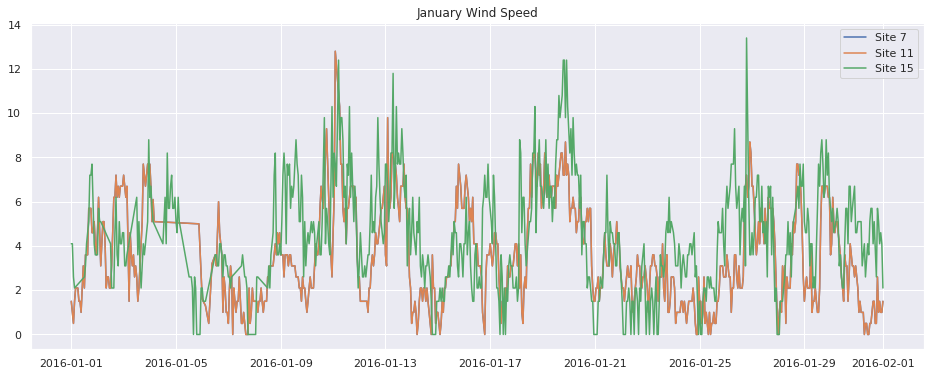

In [61]:
# Time interval to plot
start, end = datetime.date(2016, 1, 1), datetime.date(2016, 2, 1)

# Sites to plot
sites = [7, 11, 15]

# Plot wind_speed
for site in sites:
    df = weather[weather.site_id == site].drop('site_id', axis=1).set_index('timestamp')
    plt.plot(df.loc[start:end, 'wind_speed'], label=f'Site {site}')
plt.title('January Wind Speed')
plt.legend()

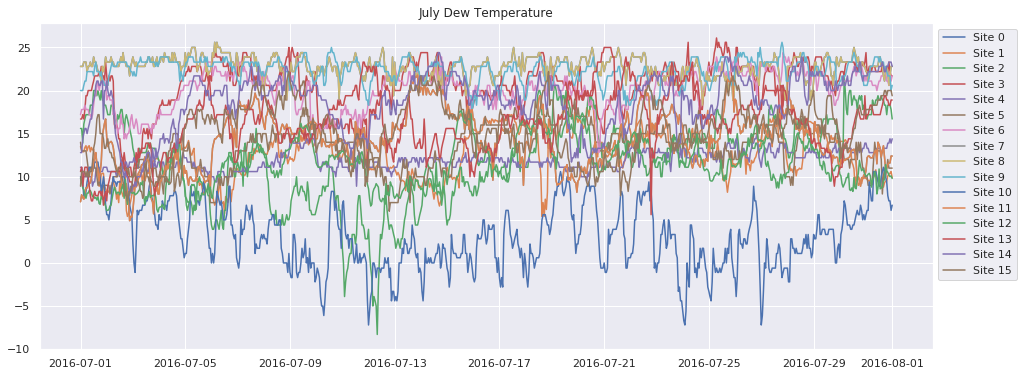

In [62]:
# Time interval to plot (check a different month)
start, end = datetime.date(2016, 7, 1), datetime.date(2016, 8, 1)

# Sites to plot
sites = weather.site_id.unique()

# Plot dew_temperature
for site in sites:
    df = weather[weather.site_id == site].drop('site_id', axis=1).set_index('timestamp')
    plt.plot(df.loc[start:end, 'dew_temperature'], label=f'Site {site}')
plt.title('July Dew Temperature')
plt.legend(bbox_to_anchor=(1, 1))

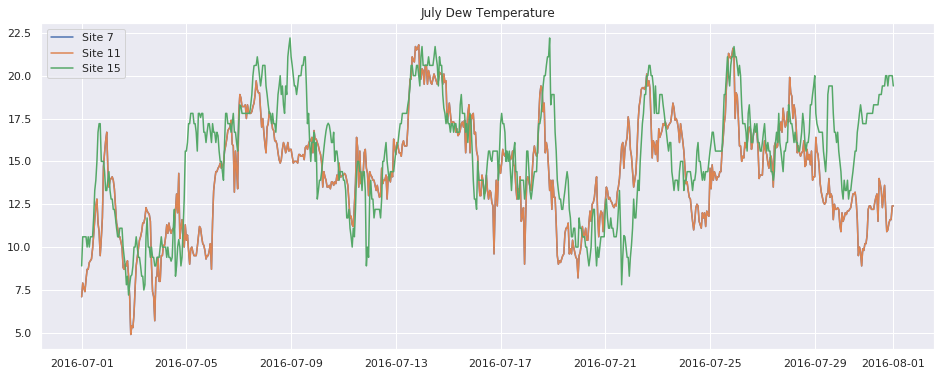

In [63]:
# Time interval to plot (check a different month)
start, end = datetime.date(2016, 7, 1), datetime.date(2016, 8, 1)

# Sites to plot
sites = [7, 11, 15]

# Plot dew_temperature
for site in sites:
    df = weather[weather.site_id == site].drop('site_id', axis=1).set_index('timestamp')
    plt.plot(df.loc[start:end, 'dew_temperature'], label=f'Site {site}')
plt.title('July Dew Temperature')
plt.legend()

Sites 7 and 11 have a perfect overlap for both `wind_speed` and `dew_temperature`, which suggests the 2 sites are next to each other. Unfortunately, both of these sites are missing `cloud_coverage` values. Aside from this, site 15 is the most similar to these 2 sites in terms of both `wind_speed` and `dew_temperature` for 2 different months. Site 15's `cloud_coverage` data will be copied over to sites 7 and 11 as a proxy.

##### Copy the `cloud_coverage` data of site 15 over to sites 7 and 11

In [64]:
# Indices of sites 7, 11, and 15
s07_idx = weather[weather.site_id == 7].index
s11_idx = weather[weather.site_id == 11].index
s15_idx = weather[weather.site_id == 15].index

# Fill missing values
weather.loc[s07_idx, 'cloud_coverage'] = weather.loc[s15_idx, 'cloud_coverage'].values
weather.loc[s11_idx, 'cloud_coverage'] = weather.loc[s15_idx, 'cloud_coverage'].values

weather[(weather.site_id == 7) | (weather.site_id == 11)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17568 entries, 61488 to 105407
Data columns (total 9 columns):
site_id               17568 non-null int64
timestamp             17568 non-null datetime64[ns]
air_temperature       17568 non-null float64
cloud_coverage        17568 non-null float64
dew_temperature       17568 non-null float64
precip_depth_1_hr     17568 non-null float64
sea_level_pressure    17568 non-null float64
wind_direction        17568 non-null float64
wind_speed            17568 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 1.3 MB


In [65]:
del start, end, s07_idx, s11_idx, s15_idx, site, sites, df

##### 1-hour precipitation depth

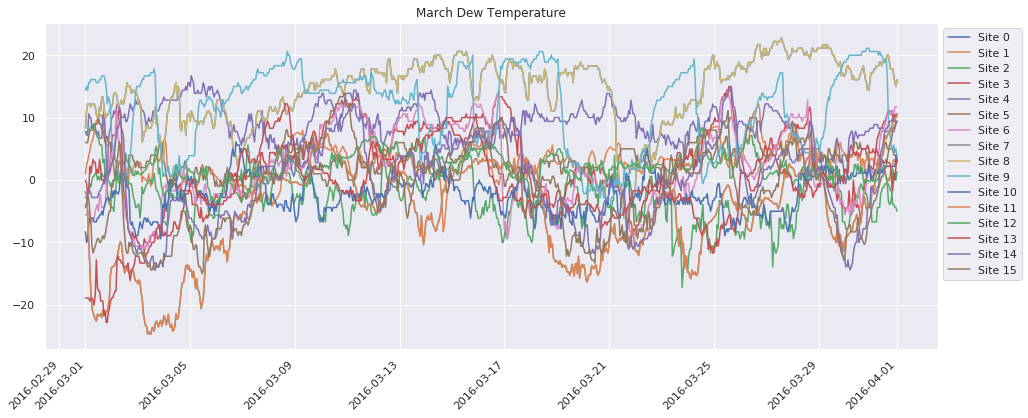

In [66]:
# Time interval to plot (check a different month)
start, end = datetime.date(2016, 3, 1), datetime.date(2016, 4, 1)

# Sites to plot
sites = weather.site_id.unique()

# Plot dew_temperature
for site in sites:
    df = weather[weather.site_id == site].drop('site_id', axis=1).set_index('timestamp')
    plt.plot(df.loc[start:end, 'dew_temperature'], label=f'Site {site}')
plt.title('March Dew Temperature')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1, 1))

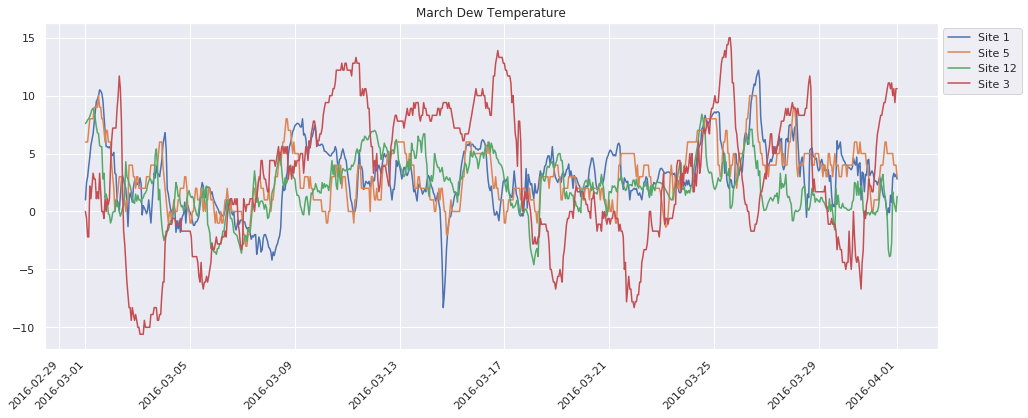

In [67]:
# Time interval to plot (check a different month)
start, end = datetime.date(2016, 3, 1), datetime.date(2016, 4, 1)

# Sites to plot
sites = [1, 5, 12, 3]

# Plot dew_temperature
for site in sites:
    df = weather[weather.site_id == site].drop('site_id', axis=1).set_index('timestamp')
    plt.plot(df.loc[start:end, 'dew_temperature'], label=f'Site {site}')
plt.title('March Dew Temperature')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1, 1))

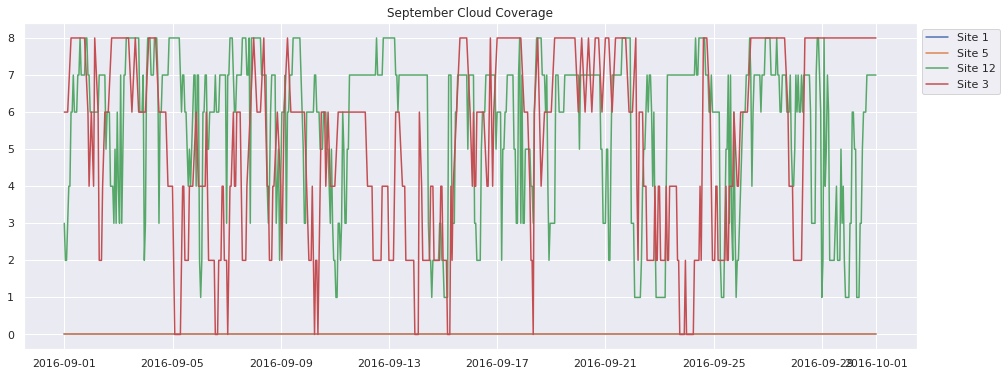

In [68]:
# Time interval to plot (check a different month)
start, end = datetime.date(2016, 9, 1), datetime.date(2016, 10, 1)

# Sites to plot
sites = [1, 5, 12, 3]

# Plot cloud_coverage
for site in sites:
    df = weather[weather.site_id == site].drop('site_id', axis=1).set_index('timestamp')
    plt.plot(df.loc[start:end, 'cloud_coverage'], label=f'Site {site}')
plt.title('September Cloud Coverage')
plt.legend(bbox_to_anchor=(1, 1))

Sites 1, 5, and 12 are the most similar in terms of `dew_temperature`. Unfortunately, the 3 closest resembling trends in dew temperature come from the 3 sites that are missing the `precip_depth_1_hr` data. These 3 sites are likely in the same vicinity so they could all share similar weather data. The next most similar site in terms of both `dew_temperature` and `cloud_coverage` is site 3. Although the difference does suggest that site 3 is not in the same area as sites 1, 5, and 12, this is the closest approximation that can be extracted from another site.

##### Copy the `precip_depth_1_hr` data of site 3 over to sites 1, 5, and 12

In [69]:
# Indices of sites 1, 5, 12, and 3
s01_idx = weather[weather.site_id == 1].index
s05_idx = weather[weather.site_id == 5].index
s12_idx = weather[weather.site_id == 12].index
s03_idx = weather[weather.site_id == 3].index

# Fill missing values
weather.loc[s01_idx, 'precip_depth_1_hr'] = weather.loc[s03_idx, 'precip_depth_1_hr'].values
weather.loc[s05_idx, 'precip_depth_1_hr'] = weather.loc[s03_idx, 'precip_depth_1_hr'].values
weather.loc[s12_idx, 'precip_depth_1_hr'] = weather.loc[s03_idx, 'precip_depth_1_hr'].values

weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 9 columns):
site_id               140544 non-null int64
timestamp             140544 non-null datetime64[ns]
air_temperature       140544 non-null float64
cloud_coverage        140544 non-null float64
dew_temperature       140544 non-null float64
precip_depth_1_hr     140544 non-null float64
sea_level_pressure    131760 non-null float64
wind_direction        140544 non-null float64
wind_speed            140544 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.7 MB


In [70]:
del start, end, s01_idx, s03_idx, s05_idx, s12_idx, site, sites, df

##### Sea-level pressure

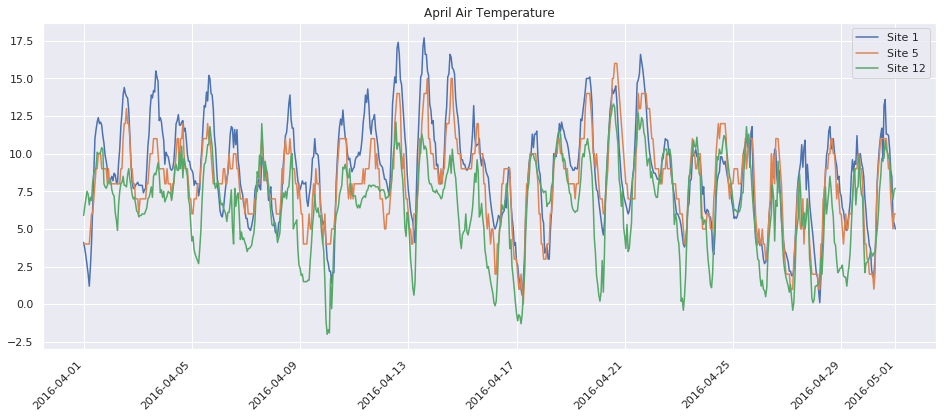

In [71]:
# Time interval to plot (check a different month)
start, end = datetime.date(2016, 4, 1), datetime.date(2016, 5, 1)

# Sites to plot
sites = [1, 5, 12]

# Plot air_temperature
for site in sites:
    df = weather[weather.site_id == site].drop('site_id', axis=1).set_index('timestamp')
    plt.plot(df.loc[start:end, 'air_temperature'], label=f'Site {site}')
plt.title('April Air Temperature')
plt.xticks(rotation=45, ha='right')
plt.legend()

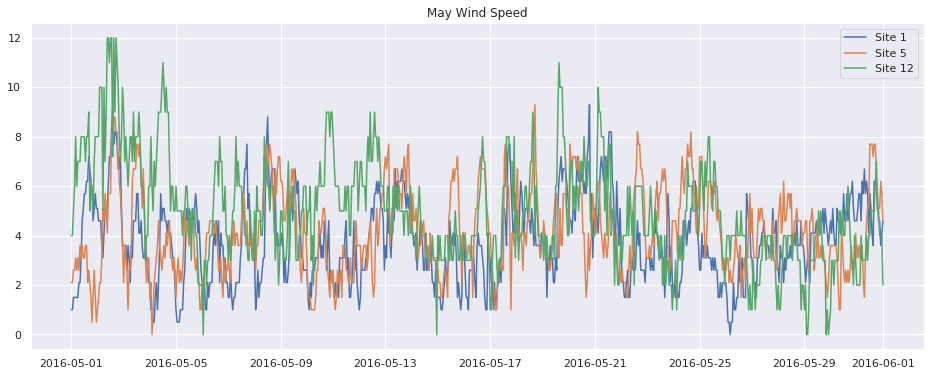

In [72]:
# Time interval to plot (check a different month)
start, end = datetime.date(2016, 5, 1), datetime.date(2016, 6, 1)

# Sites to plot
sites = [1, 5, 12]

# Plot wind_speed
for site in sites:
    df = weather[weather.site_id == site].drop('site_id', axis=1).set_index('timestamp')
    plt.plot(df.loc[start:end, 'wind_speed'], label=f'Site {site}')
plt.title('May Wind Speed')
plt.legend()

The `air_temperature` plot and `wind_speed` plot both agree with the above assessment that sites 1, 5, and 12 are in the same general vicinity. It does look like sites 1 and 5 are closer to each other so the `sea_level_pressure` data from site 1 will also be used for site 5.

##### Copy the `sea_level_pressure` data of site 1 over to site 5

In [73]:
# Indices of sites 5 and 1
s05_idx = weather[weather.site_id == 5].index
s01_idx = weather[weather.site_id == 1].index

# Fill missing values
weather.loc[s05_idx, 'sea_level_pressure'] = weather.loc[s01_idx, 'sea_level_pressure'].values
weather[weather.site_id == 5].head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
43920,5,2016-01-01 00:00:00,5.0,0.0,2.0,0.0,1020.9,260.0,2.6
43921,5,2016-01-01 01:00:00,5.0,0.0,2.0,0.0,1021.6,260.0,2.6
43922,5,2016-01-01 02:00:00,3.0,0.0,1.0,0.0,1021.9,210.0,1.5
43923,5,2016-01-01 03:00:00,4.0,0.0,3.0,0.0,1022.3,160.0,2.6
43924,5,2016-01-01 04:00:00,4.0,0.0,3.0,0.0,1022.7,110.0,4.1


In [74]:
del start, end, s01_idx, s05_idx, site, sites, df
del pctmissing_bysite
gc.collect()

279

Now the weather data is complete, but note that the columns in the following sites are using data from another site as a proxy.
- Site 1: `precip_depth_1_hr` (from site 3)
- Site 5: `precip_depth_1_hr` (from site 3)
- Site 5: `sea_level_pressure` (from site 1)
- Site 7: `cloud_coverage` (from site 15)
- Site 11: `cloud_coverage` (from site 15)
- Site 12: `precip_depth_1_hr` (from site 3)

##### Cast `cloud_coverage` and `wind_direction` into integer types

In [75]:
weather.cloud_coverage = weather.cloud_coverage.astype(int)
weather.wind_direction = weather.wind_direction.astype(int)

weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 9 columns):
site_id               140544 non-null int64
timestamp             140544 non-null datetime64[ns]
air_temperature       140544 non-null float64
cloud_coverage        140544 non-null int64
dew_temperature       140544 non-null float64
precip_depth_1_hr     140544 non-null float64
sea_level_pressure    140544 non-null float64
wind_direction        140544 non-null int64
wind_speed            140544 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 9.7 MB


<a id='cleaning_metr'></a>
### Meter Cleaning
[Back to 3. Data Cleaning](#cleaning)

##### Inspect the data

In [76]:
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        datetime64[ns]
meter_reading    float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 616.9 MB


In [77]:
meter.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [78]:
# Check for duplicates
meter.duplicated(subset=['building_id', 'meter', 'timestamp']).sum()

0

In [79]:
print(f'There should be {366 * 24} timestamps recorded in the meter data')
print(f'There are {meter.timestamp.nunique()} timestamps')

There should be 8784 timestamps recorded in the meter data
There are 8784 timestamps


In [80]:
print(f'There should be {building.building_id.nunique()} buildings recorded in the meter data')
print(f'There are {meter.building_id.nunique()} buildings')

There should be 1449 buildings recorded in the meter data
There are 1449 buildings


<a id='cleaning_ref1_back'></a>
There are no duplicates and no missing data here. There are records for every hour of every single day in 2016 and records for every building in the meter data. Although there are no missing timestamps in the data as a whole, there may actually be a lot of buildings that are missing timestamps so that will be explored more in the analysis. All the columns have a reasonable range of values and the correct data type so no changes have to be made for the meter data. But it would be helpful to label each meter with the corresponding type.

##### Add a new column to specify what type of meter each number code is referring to

In [81]:
metr_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

meter['type'] = meter.meter.map(metr_types)
meter.head()

,building_id,meter,timestamp,meter_reading,type
0,0,0,2016-01-01,0.0,electricity
1,1,0,2016-01-01,0.0,electricity
2,2,0,2016-01-01,0.0,electricity
3,3,0,2016-01-01,0.0,electricity
4,4,0,2016-01-01,0.0,electricity


The electricity meter readings from site 0 are in kBTU. This is inconsistent with the rest of the data, which is in kWh.

##### Convert the electricity meter readings from site 0 from kBTU to kWh

In [82]:
# Add site_id to meter
meter = pd.merge(meter, building[['site_id', 'building_id']], how='left', on='building_id')

# Reorder columns
meter = meter[['site_id', 'building_id', 'meter', 'type', 'timestamp', 'meter_reading']]

# Positive meter readings in site 0
meter[(meter.site_id == 0) & (meter.meter_reading > 0)].head(10)

,site_id,building_id,meter,type,timestamp,meter_reading
45,0,46,0,electricity,2016-01-01 00:00:00,53.2397
72,0,74,0,electricity,2016-01-01 00:00:00,43.0013
91,0,93,0,electricity,2016-01-01 00:00:00,52.4206
2321,0,20,0,electricity,2016-01-01 01:00:00,91.9886
2346,0,46,0,electricity,2016-01-01 01:00:00,53.6492
4639,0,46,0,electricity,2016-01-01 02:00:00,54.8778
6938,0,46,0,electricity,2016-01-01 03:00:00,53.6492
6987,0,96,0,electricity,2016-01-01 03:00:00,33.2748
9234,0,46,0,electricity,2016-01-01 04:00:00,53.6492
11530,0,46,0,electricity,2016-01-01 05:00:00,54.4683


In [83]:
# 1 kBTU * 0.2931 = 1 kWh
meter.loc[(meter.site_id == 0) & (meter.type == 'electricity'), 'meter_reading'] *= 0.2931
meter[(meter.site_id == 0) & (meter.meter_reading > 0)].head(10)

,site_id,building_id,meter,type,timestamp,meter_reading
45,0,46,0,electricity,2016-01-01 00:00:00,15.604556
72,0,74,0,electricity,2016-01-01 00:00:00,12.603681
91,0,93,0,electricity,2016-01-01 00:00:00,15.364478
2321,0,20,0,electricity,2016-01-01 01:00:00,26.961859
2346,0,46,0,electricity,2016-01-01 01:00:00,15.724581
4639,0,46,0,electricity,2016-01-01 02:00:00,16.084683
6938,0,46,0,electricity,2016-01-01 03:00:00,15.724581
6987,0,96,0,electricity,2016-01-01 03:00:00,9.752844
9234,0,46,0,electricity,2016-01-01 04:00:00,15.724581
11530,0,46,0,electricity,2016-01-01 05:00:00,15.964659


Going back to the issue referenced [here](#cleaning_ref1), the building metadata contains buildings opened in 2016 and 2017 even though this is a dataset of measurements from the beginning to end of 2016.

##### Identify buildings opened in 2016 and 2017 and check these buildings in the meter data

In [84]:
yearblt_1617 = building[(building.year_built == 2016) | (building.year_built == 2017)]
yearblt_1617

,site_id,building_id,primary_use,square_feet,year_built,floor_count
28,0,28,Office,52957,2016,2
45,0,45,Retail,15304,2016,1
46,0,46,Retail,9045,2016,1
99,0,99,Office,2260,2016,1
103,0,103,Education,21657,2016,1
363,3,363,Education,69300,2017,3
409,3,409,Education,38500,2016,2
567,4,567,Entertainment/public assembly,82670,2016,4


In [85]:
# Calculate meter_reading counts for each building
bldg_1617 = yearblt_1617.building_id.tolist()
metr_1617 = [meter[meter.building_id == bldg].shape[0] for bldg in bldg_1617]

# Calculate the total count
bldg_1617.append('Total')
metr_1617.append(sum(metr_1617))

# Convert to dataframe
_1617 = pd.DataFrame(zip(bldg_1617, metr_1617), columns=['building', 'meter_reading_count'])
_1617

,building,meter_reading_count
0,28,14991
1,45,8783
2,46,8784
3,99,8784
4,103,15983
5,363,8782
6,409,8782
7,567,3465
8,Total,78354


There are 7 buildings from 3 different sites that opened in 2016 and 1 building that opened in 2017. Almost 80 thousand of the meter readings are from these 8 buildings. As stated in the [data description](#description), the `year_built` column is recorded as the year the building opened so it's possible measurements were taken during construction of these buildings. This data could still be usable, but these measurements don't accurately represent the normal energy consumption of that type of building. If it is the case that these measurements are "in-construction" measurements, then these 8 buildings actually belong in their own `primary_use` category to avoid affecting the data of those types of buildings. But for now these 8 buildings will keep `primary_use` value in case it needs to be referenced later. Instead, a new feature will be added to the building metadata to specify whether or not it is in construction.*

*Note: This added column is only an assumption created for these 8 buildings that opened in 2016 and 2017.

##### Add a new column with values of 1 (representing in construction) and 0 (representing not in construction)

In [86]:
building['in_construction'] = building.year_built.apply(lambda y: 1 if y in [2016, 2017] else 0)
building[(building.year_built == 2015) | (building.year_built == 2016) | (building.year_built == 2017)]

,site_id,building_id,primary_use,square_feet,year_built,floor_count,in_construction
28,0,28,Office,52957,2016,2,1
45,0,45,Retail,15304,2016,1,1
46,0,46,Retail,9045,2016,1,1
99,0,99,Office,2260,2016,1,1
103,0,103,Education,21657,2016,1,1
302,3,302,Education,57100,2015,2,0
363,3,363,Education,69300,2017,3,1
409,3,409,Education,38500,2016,2,1
559,3,559,Education,48994,2015,2,0
567,4,567,Entertainment/public assembly,82670,2016,4,1


In [87]:
del metr_types, yearblt_1617, bldg_1617, metr_1617
gc.collect()

44

<a id='output1'></a>
## 4. Output
[Back to top](#content1)

With all the missing values imputed and nonsensical values corrected, the data should now be ready for some exploratory analysis and preprocessing.

##### Inspect the data to confirm this

In [88]:
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 7 columns):
site_id            1449 non-null int64
building_id        1449 non-null int64
primary_use        1449 non-null object
square_feet        1449 non-null int64
year_built         1449 non-null int64
floor_count        1449 non-null int64
in_construction    1449 non-null int64
dtypes: int64(6), object(1)
memory usage: 79.4+ KB


In [89]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 9 columns):
site_id               140544 non-null int64
timestamp             140544 non-null datetime64[ns]
air_temperature       140544 non-null float64
cloud_coverage        140544 non-null int64
dew_temperature       140544 non-null float64
precip_depth_1_hr     140544 non-null float64
sea_level_pressure    140544 non-null float64
wind_direction        140544 non-null int64
wind_speed            140544 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 9.7 MB


In [90]:
meter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 6 columns):
site_id          int64
building_id      int64
meter            int64
type             object
timestamp        datetime64[ns]
meter_reading    float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.1+ GB


##### Save all 3 dataframes into csv files

In [91]:
building.to_csv('../data/clean/clean_building.csv')
weather.to_csv('../data/clean/clean_weather.csv')
meter.to_csv('../data/clean/clean_meter.csv')